In [1]:
import pandas as pd
import numpy as np
import numerapi
import sklearn.linear_model
import matplotlib.pylab as plt

from datetime import timedelta
import tqdm

In [2]:
df = pd.DataFrame(data={'Animal': ['cat', 'penguin', 'dog',
                                   'spider', 'snake'],
                        'Number_legs': [4, 2, 4, 8, np.nan]})
df['pct_rank'] = df['Number_legs'].rank(pct=True)
df['pct_rank_1'] = df['Number_legs'].rank(pct=True, method = "first")

In [3]:
df

,Animal,Number_legs,pct_rank,pct_rank_1
0,cat,4.0,0.625,0.50
1,penguin,2.0,0.250,0.25
2,dog,4.0,0.625,0.75
3,spider,8.0,1.000,1.00
4,snake,NaN,NaN,NaN


In [4]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

In [5]:
training_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_training_data.csv.xz")
training_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,...,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,...,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,...,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,...,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,...,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [6]:
# download the latest tournament dataset (takes around 30s)
tournament_data = pd.read_csv("https://numerai-public-datasets.s3-us-west-2.amazonaws.com/latest_numerai_tournament_data.csv.xz")
tournament_data.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,...,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,...,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,...,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,...,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,...,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [7]:
# find only the feature columns
feature_cols = training_data.columns[training_data.columns.str.startswith('feature')]

In [8]:
# select those columns out of the training dataset
training_features = training_data[feature_cols]

In [10]:
target = training_data['target']

In [11]:
eras = training_data['era']
eras_live = tournament_data.era

In [12]:
N_ERAS_IN_FOLD = 12
N_FOLDS = int(len(eras.unique()) / N_ERAS_IN_FOLD)

eras2_binned = []
current_era = 1
thresh_era_limit = N_ERAS_IN_FOLD
for era in eras:
    era_num = int(era.split('era')[-1])
    if era_num <= thresh_era_limit:
        eras2_binned.append(current_era)
    else:
        current_era += 1
        thresh_era_limit += N_ERAS_IN_FOLD
        eras2_binned.append(current_era)

In [13]:
validation_ids = tournament_data.data_type=='validation'

### Feature importance

In [14]:
from sklearn.linear_model import RidgeClassifier

from sklearn.metrics import log_loss, accuracy_score
from sklearn import model_selection

from scipy.cluster.hierarchy import linkage, fcluster
from itertools import product

In [15]:
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [16]:
REFERENCES = [0.0, 0.25, 0.5, 0.75, 1.0]

In [17]:
def get_base_model(cw = {0: 1,
                          1: 1.1,
                          2: 1,
                          3: 1.1,
                          4: 1
                        }):
    return RidgeClassifier(alpha = 1, 
                           class_weight = cw
                                    )
    
def ridge_classifier_2single_prediction(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

def train_model(X_train, Y_train, model = None):
    if model == None:
        model_i = get_base_model()
    else:
        model_i = model
    model_i.fit(X_train, Y_train)
    return model_i

def calculate_score(train_data, predictions, eras):

    ns = numerai_score(train_data, pd.Series(predictions))
    cs = correlation_score(train_data, pd.Series(predictions))

    df2 = pd.DataFrame(
        {
            "era": eras,
            "preds": predictions,
            "target": train_data
        }
    )

    scores_per_era = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

    per_era_score, per_era_std = scores_per_era.mean(), scores_per_era.std()
    sharpe_era_score = scores_per_era.mean() / scores_per_era.std()
    return ns, cs, per_era_score, per_era_std, sharpe_era_score


def ridge2probas(model, X, temperature = 1.0):
    try:
        predictions_proba_mean = model.decision_function(X)
    except:
        predictions_proba_mean = model.predict_proba(X)
    predictions = np.argmax(predictions_proba_mean, axis=1)
    predictions_proba = np.array([np.exp(di / temperature) / np.sum(np.exp(di / temperature)) for di in predictions_proba_mean])
    return predictions_proba

def softmax2singlescore(predictions_proba):
    single_score_predictions = np.array(
            [
                sum(REFERENCES[i] * x[i] for i in range(len(REFERENCES))) for x in predictions_proba
            ]
        )

    return single_score_predictions

# Baseline

In [18]:
validation_ids = tournament_data.data_type=='validation'
tournament_data = tournament_data[validation_ids]

In [19]:
le = LabelEncoder()

X = training_features
Y = le.fit_transform(target)
Y_nmr = target

In [21]:
X_test = tournament_data[feature_cols]
Y_test = le.fit_transform(tournament_data.target)
Y_nmr_test = tournament_data.target
test_eras = tournament_data.era

In [22]:
clf = get_base_model()
clf.fit(X, Y)
pred_c = clf.predict(X_test)
pred = ridge_classifier_2single_prediction(clf, X_test)

In [24]:
print(classification_report(pred_c, Y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.01      0.23      0.01       709
           2       0.99      0.50      0.67    135810
           3       0.01      0.23      0.02      1260
           4       0.00      0.00      0.00         0

    accuracy                           0.50    137779
   macro avg       0.20      0.19      0.14    137779
weighted avg       0.98      0.50      0.66    137779



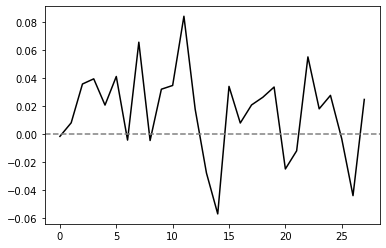

corr_spearman    = 0.016
corr_pearson     = 0.015
per_era_avg_corr = 0.016
per_era_std_corr = 0.031
sharpe_era_corr  = 0.51


In [25]:
ns_bs = numerai_score(Y_nmr_test, pd.Series(pred))
cs_bs = correlation_score(Y_nmr_test, pd.Series(pred))

df2 = pd.DataFrame(
    {
        "era": test_eras,
        "preds": pred,
        "target": Y_nmr_test
    }
)

scores_per_era_bs = df2.groupby("era").apply(lambda d: np.corrcoef(d["preds"], d["target"])[0,1])

per_era_score, per_era_std = scores_per_era_bs.mean(), scores_per_era_bs.std()
sharpe_era_score = scores_per_era_bs.mean() / scores_per_era_bs.std()

plt.figure()
plt.plot(scores_per_era_bs.values, color = 'black')
plt.axhline(0.0, ls = '--', color = 'grey')
plt.show()
print('corr_spearman    = {}'.format(round(ns_bs, 3)))
print('corr_pearson     = {}'.format(round(cs_bs, 3)))
print('per_era_avg_corr = {}'.format(round(per_era_score, 3)))
print('per_era_std_corr = {}'.format(round(per_era_std, 3)))
print('sharpe_era_corr  = {}'.format(round(sharpe_era_score, 3)))

In [56]:
def featImpMDA(X, y, cv, eras_groups):

    cvGen = model_selection.GroupKFold(cv)
    X_old = X.copy()
    scr0,scr1=pd.Series(), pd.DataFrame(columns=X.columns)

    for i, (train,test) in tqdm.tqdm(enumerate(cvGen.split(X=X, groups = eras_groups))):


        X0, y0 = X.iloc[train, :], y[train]
        X1, y1 = X.iloc[test, :], y[test] 
        # eras_test = pd.Series(eras2_binned).iloc[test]
        eras_test = pd.Series(eras_groups).iloc[test]

        clf = get_base_model()
        clf.fit(X=X0,y=y0)
        y1 = le.inverse_transform(y1)

        # pred = fit.predict(X1)
        pred = ridge_classifier_2single_prediction(clf, X1)

        # scr0.loc[i]=correlation_score(y1,pred)
        sharpes_metrics = calculate_score(y1, pred, eras_test)
        scr0.loc[i] = sharpes_metrics[0]

        for j in X.columns:

            X1_ = X1.copy(deep=True)
            np.random.shuffle(X1_[j].values) # permutation of a single column

            pred_shuffled = ridge_classifier_2single_prediction(clf, X1_)

            # scr1.loc[i,j]=correlation_score(y1,pred_shuffled)
            sharpes_metrics_shuffled = calculate_score(y1, pred_shuffled, eras_test)
            scr1.loc[i,j] = sharpes_metrics_shuffled[0]

    imp=(-scr1).add(scr0,axis=0)
    imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    return imp,scr0.mean()

## Selecting importances features

In [57]:
X_FOR_FEATURE_IMPORTANCE = X[:int(len(X)/2)]
Y_FOR_FEATURE_IMPORTANCE = Y[:int(len(Y)/2)]
ERAS_FOR_FI = eras2_binned[:int(len(eras2_binned)/2)]

In [58]:
importances, oos = featImpMDA(X=X_FOR_FEATURE_IMPORTANCE, 
                               y=Y_FOR_FEATURE_IMPORTANCE,
                               cv = 5,
                               eras_groups = ERAS_FOR_FI)

5it [17:38, 211.78s/it]


In [64]:
importances

,mean,std
feature_intelligence1,0.001990,0.000813
feature_intelligence2,0.004476,0.001423
feature_intelligence3,0.001649,0.000755
feature_intelligence4,0.000346,0.000488
feature_intelligence5,0.000038,0.000432
...,...,...
feature_wisdom42,-0.000224,0.000219
feature_wisdom43,0.000089,0.000216
feature_wisdom44,0.000255,0.000172
feature_wisdom45,0.000659,0.000442


In [60]:
# importances_more_zero = importances[importances['mean'] - importances['std']  > 0]
# importances_more_zero['mean_std_diff'] = importances_more_zero['mean'] - importances_more_zero['std']
importances_more_zero = importances[importances['mean']  > 0]
# importances_more_zero = importances.sort_values('mean')[::-1]

In [62]:
DOWN, UP = 0, 100
COLUMN = 'mean'

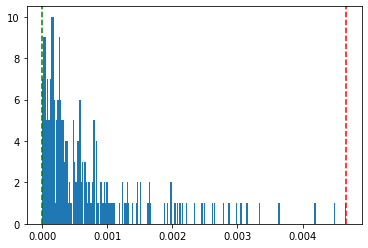

In [63]:
plt.figure()
plt.hist(importances_more_zero[COLUMN].values, bins = len(importances_more_zero))
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, UP), ls = '--', color = 'red')
plt.axvline(np.percentile(importances_more_zero[COLUMN].values, DOWN), ls = '--', color = 'green')
plt.show()

In [88]:
up_limit = np.percentile(importances_more_zero[COLUMN].values, UP)
bot_limit = np.percentile(importances_more_zero[COLUMN].values, DOWN)
bot_limit, up_limit

(4.800005927508709e-07, 0.004671597726559708)

In [89]:
mask = (importances_more_zero[COLUMN] < up_limit) & (importances_more_zero[COLUMN] > bot_limit)
IMPORTANT_FEATURES = importances_more_zero[mask].index.tolist()
len(IMPORTANT_FEATURES)

235

In [81]:
scr_0 = 0.2
scr_1 = 0.4

In [82]:
imp = -scr_1 + scr_0

In [84]:
imp

-0.2

In [83]:
imp/(1.-scr_1)

-0.33333333333333337

In [74]:
(1.-scr_1)

1.1